In [1]:
%load_ext autoreload
%autoreload 2

from example_robot_data import load
from pinocchio.visualize import MeshcatVisualizer
import numpy as np
import time
import pinocchio as pin

# Robotics Course : Control Exercise

This exercise requires an additional package (rockit), which was not installed in the default software environment.

This package can be installed via: ``pip install rockit-meco``

## Part 1 : Implement a joint-space controller

In this task, the goal is to implement a joint-space controller that also compensates for the nonlinear dynamics of the robot.
Specifically, your role is to implement the controller in the figure below. Some code is provided, such as a (basic) motion planner, and a simulation environment.

<p align="center">
    <img src="figures/jointservo.svg" width="80%">
</p>

### Questions
- 1.1 Implement the controller shown in the figure above within the ``controller`` python function.
- 1.2 Investigate the role of the feedforward and feedback terms.
  - 1.2.1 What happens without the feedforward terms ($\dot{q}_\text{des}$ and $\ddot{q}_\text{des}$)? Can you increase the feedback gains to compensate?
  - 1.2.1 What happens if there is no model mismatch? Is the feedback still necessary?
- 1.3 What happens of you remove the motion planner, and directly supply the goal position to the controller?
- 1.4 How would you modify the controller to only receive a velocity reference?

### Load a robot and create a visualization environment

In [2]:
# load a robot from the example robot data
robot = load("ur10")

# create a vizualizer
viz = MeshcatVisualizer(robot.model, robot.collision_model, robot.visual_model)
viz.initViewer(loadModel=True)

# set the start position and show the robot
robot.q0 = np.array([np.pi, -np.pi/2, 4.5, 4.6, np.pi/2, 0])
viz.display(robot.q0)
# viz.viewer.jupyter_cell() #uncomment to view in notebook

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


### Define the feedback controller

TODO: implement your feedback controller here

In [3]:
def controller(q_actual, dq_actual, q_des=0, dq_des=0, ddq_des=0):
    """
    Controller function to compute the torque based on desired and actual positions and velocities.

    Args:
        q_actual (np.ndarray): Actual positions.
        dq_actual (np.ndarray): Actual velocities.
        q_des (np.ndarray): Desired positions.
        dq_des (np.ndarray): Desired velocities.
        ddq_des (np.ndarray): Desired acceleration.

    Returns:
        np.ndarray: Computed torques to be applied.
    """

    # define the reponse of the controller:
    zeta = 0.707 # damping ratio
    wn = 10 # natural frequency

    ##################################

    # TODO: implement the controller. Hint, use pinocchio to compute the inverse dynamics (pin.rnea)
    torque = np.zeros(robot.model.nq)
    ddq_actual = ddq_des - 2*zeta*wn*(dq_actual - dq_des) - wn*(q_actual - q_des) # see slides for this formula
    torque = pin.rnea(robot.model, robot.data, q_actual, dq_actual, ddq_actual)

    ##################################

    return torque

### The simulation loop

In [6]:
# create a torque robot simulation
from utils.robot_simulator import TorqueRobotSim
robot_sim = TorqueRobotSim(robot, add_model_mismatch = True) # change to false for acurate results

# set parameters for the simulation
control_freq = 200 #hz
render_freq = 32 #hz
sim_time = 3 #sec

# reset the robot to starting position
robot_sim.reset()

# generate a motion from current position to goal
from utils.motion_generator import MotionPlanner
q_start = robot_sim.get_joint_pos()
q_goal = q_start + 0.7
motion = MotionPlanner(q_start, q_goal, dq_max= 0.5, ddq_max=0.5)

# start the simulation loop
for t in np.arange(0, sim_time, 1/control_freq):
    # get the current position and velocity of the robot
    q, dq = robot_sim.get_joint_state()

    # ask the motion generator for the joint position, velocity, and acceleration reference.
    q_des, dq_des, ddq_des = motion(t)

    # run the controller with the specified motion
    torque = controller(q, dq, q_des, dq_des, ddq_des)

    # uncomment to run the controller without feedforward
    # torque = controller(q, dq, q_des, 0, 0)

    # uncomment to run the controller without motion generator
    # torque = controller(q, dq, q_goal, 0, 0)

    # simulate the robot
    robot_sim.step(torque, 1/control_freq)

    # update the vizualization at the correct rate
    if t % (1/render_freq) < 1/control_freq:
        viz.display(q)
        time.sleep(1 / render_freq)

### Plot the results

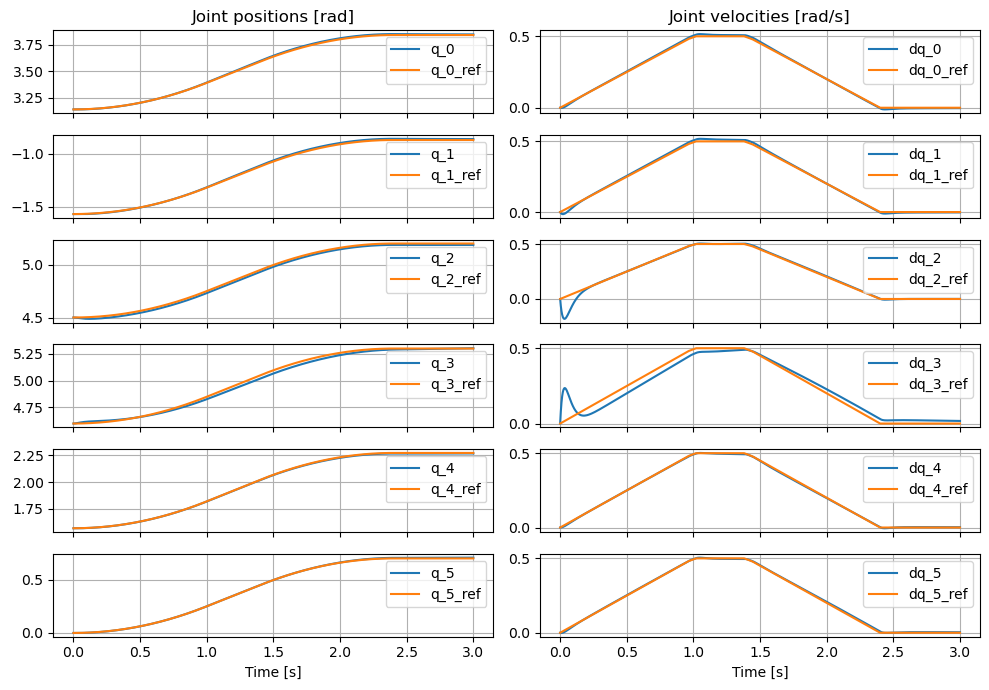

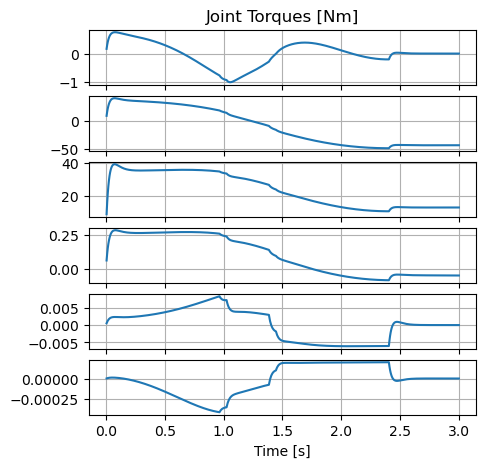

In [5]:
from matplotlib import pyplot as plt

# generate a plot for the joint positions
fig, axs = plt.subplots(6, 2, figsize=(10, 7), sharex=True)

# Set titles for each column
axs[0, 0].set_title("Joint positions [rad]")
axs[0, 1].set_title("Joint velocities [rad/s]")
axs[-1, 0].set_xlabel("Time [s]")
axs[-1, 1].set_xlabel("Time [s]")

q_des_arr, dq_des_arr, ddq_des_arr = motion(robot_sim.t_list)

for i in range(6):
    # Plot joint positions
    axs[i, 0].plot(robot_sim.t_list, np.array(robot_sim.q_list)[:, i], label='q_'+str(i))
    axs[i, 0].plot(robot_sim.t_list, q_des_arr[:, i], label='q_'+str(i)+"_ref")
    axs[i, 0].legend()
    axs[i, 0].grid(True)
    
    # Plot joint velocities
    axs[i, 1].plot(robot_sim.t_list, np.array(robot_sim.dq_list)[:, i], label='dq_'+str(i))
    axs[i, 1].plot(robot_sim.t_list, dq_des_arr[:, i], label='dq_'+str(i)+"_ref")
    axs[i, 1].legend()
    axs[i, 1].grid(True)

# Add x label

plt.tight_layout()
plt.show()

# plot all the joint torques
fig, ax = plt.subplots(6,1,figsize=(5, 5))
for i in range(6):
    ax[i].plot(robot_sim.t_list[1:], np.array(robot_sim.u_list)[:, i], label='torque_'+str(i))
    ax[i].grid(True)

ax[0].set_title("Joint Torques [Nm]")
ax[-1].set_xlabel("Time [s]")
plt.show()